# 04 - Machine Learning Models

This notebook covers:
- Training and evaluating ML models with TF-IDF features
- Training and evaluating ML models with BERT embeddings
- Training and evaluating ML models with Doc2Vec embeddings
- MLP Classifier
- Model comparison and XAI with LIME

## Import Libraries

In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4239111caf07b0fd75939be1cf2fc084fec0266522b1b57561f9957c5d7441f3
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [3]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import lime
import lime.lime_text
from lime.lime_text import LimeTextExplainer
import pickle
import warnings

warnings.filterwarnings('ignore')

## Load Preprocessed Data and Features

In [9]:
df = pd.read_csv("/content/sample_data/Phishing_Email_Preprocessed.csv")

with open('/content/sample_data/tfidf_features.pkl', 'rb') as f:
    x_full_train, x_full_test, y_full_train, y_full_test, tf = pickle.load(f)


X_train_doc = np.load('/content/sample_data/doc2vec_train.npy')
X_test_doc = np.load('/content/sample_data/doc2vec_test.npy')
y_train_doc = np.load('/content/sample_data/doc2vec_train_labels.npy')
y_test_doc = np.load('/content/sample_data/doc2vec_test_labels.npy')

print("Data loaded successfully!")

Data loaded successfully!


In [ ]:
df = pd.read_csv("/content/sample_data/Phishing_Email_Preprocessed.csv")

with open('/content/sample_data/tfidf_features.pkl', 'rb') as f:
    x_full_train, x_full_test, y_full_train, y_full_test, tf = pickle.load(f)

X_train_bert = np.load('bert_train.npy')
X_test_bert = np.load('bert_test.npy')
y_train_bert = np.load('bert_train_labels.npy')
y_test_bert = np.load('bert_test_labels.npy')

X_train_doc = np.load('doc2vec_train.npy')
X_test_doc = np.load('doc2vec_test.npy')
y_train_doc = np.load('doc2vec_train_labels.npy')
y_test_doc = np.load('doc2vec_test_labels.npy')

print("Data loaded successfully!")

## Model Comparison Function

In [10]:
from typing import Dict, Any, Optional
from sklearn.base import ClassifierMixin

def compare_models(X_train: np.ndarray, X_test: np.ndarray,
                   y_train: np.ndarray, y_test: np.ndarray,
                   models = None,
                   output_csv: str = "comparaison_modeles.csv",
                   cv_splits: int = 3):

    if models is None:
        models = {
            "Random Forest": RandomForestClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "SVM": SVC(probability=True),
            "Naive Bayes": MultinomialNB(),
            "KNN": KNeighborsClassifier(n_neighbors=5)
        }

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    results = []
    trained_models = {}

    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        print(f"\n📌 Evaluating {name}...\n")
        if isinstance(model, type):
            model = model()

        cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
        cv_mean = np.mean(cv_scores)
        cv_std = np.std(cv_scores)
        print(f"  Cross-Validation Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")

        start_train = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_train

        start_pred = time.time()
        y_pred = model.predict(X_test)
        pred_time = time.time() - start_pred

        print(f"  Training Time: {train_time:.4f}s, Prediction Time: {pred_time:.6f}s")

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred)

        print(f"  Accuracy  = {acc:.4f}")
        print(f"  Precision = {prec:.4f}")
        print(f"  Recall    = {rec:.4f}")
        print(f"  F1 Score  = {f1:.4f}")
        print(f"  AUC-ROC   = {auc_roc:.4f}")
        auc_roc = "N/A"

        try:
            y_probs = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_probs)
            auc_roc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.4f})')
        except Exception as e:
            print(f"  ⚠️ Could not compute ROC curve for {name}: {e}")

        cm = confusion_matrix(y_test, y_pred)
        plt_cm = plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['Not Phishing', 'Phishing'],
                    yticklabels=['Not Phishing', 'Phishing'])
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        results.append({
            "Model": name,
            "CV Accuracy Mean": round(cv_mean, 4),
            "CV Std": round(cv_std, 4),
            "Train Time (s)": round(train_time, 4),
            "Pred Time (s)": round(pred_time, 6),
            "Accuracy": round(acc, 4),
            "Precision": round(prec, 4),
            "Recall": round(rec, 4),
            "F1 Score": round(f1, 4),
            "AUC-ROC": round(auc_roc, 4) if auc_roc != "N/A" else "N/A"
        })

        trained_models[name] = model

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

    results_df = pd.DataFrame(results)
    print("\n📋 Résultats Comparatifs :")
    print(results_df)

    results_df.to_csv(output_csv, index=False)
    print(f"\n✅ Résultats exportés dans '{output_csv}'")

    return results_df, trained_models

## Compare Models for TF-IDF


📌 Evaluating Random Forest...

  Cross-Validation Accuracy: 0.9659 ± 0.0023
  Training Time: 23.5564s, Prediction Time: 0.168586s
  Accuracy  = 0.9746
  Precision = 0.9859
  Recall    = 0.9726
  F1 Score  = 0.9792
  AUC-ROC   = 0.9752


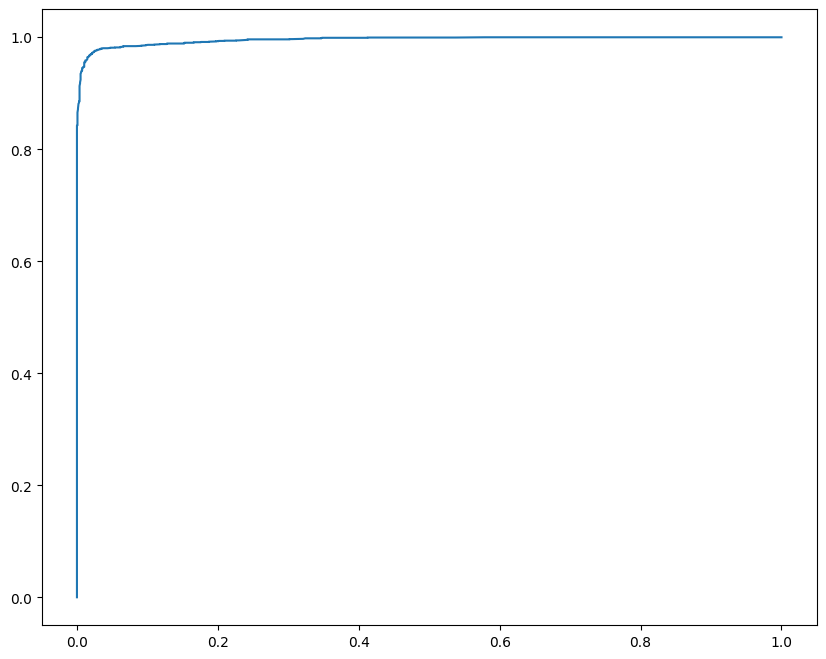

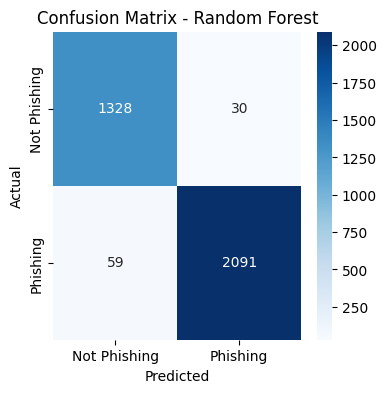


📌 Evaluating XGBoost...

  Cross-Validation Accuracy: 0.9616 ± 0.0010
  Training Time: 45.8504s, Prediction Time: 0.020154s
  Accuracy  = 0.9721
  Precision = 0.9808
  Recall    = 0.9735
  F1 Score  = 0.9771
  AUC-ROC   = 0.9716


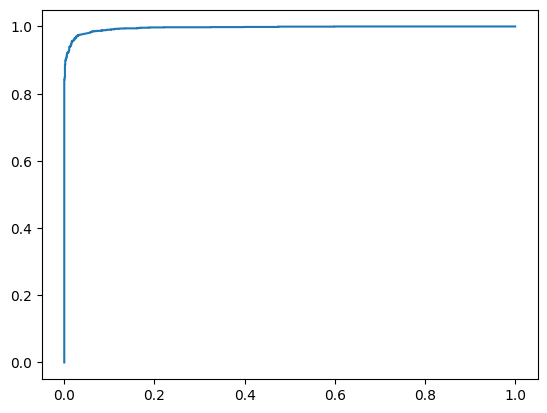

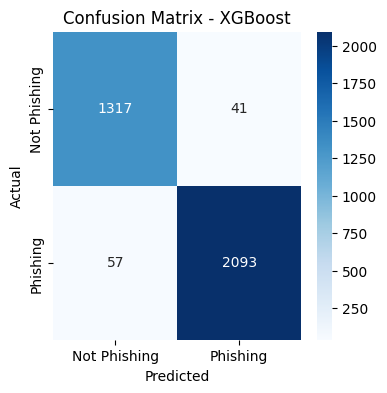


📌 Evaluating Logistic Regression...

  Cross-Validation Accuracy: 0.9690 ± 0.0034
  Training Time: 0.2970s, Prediction Time: 0.001462s
  Accuracy  = 0.9769
  Precision = 0.9769
  Recall    = 0.9856
  F1 Score  = 0.9812
  AUC-ROC   = 0.9744


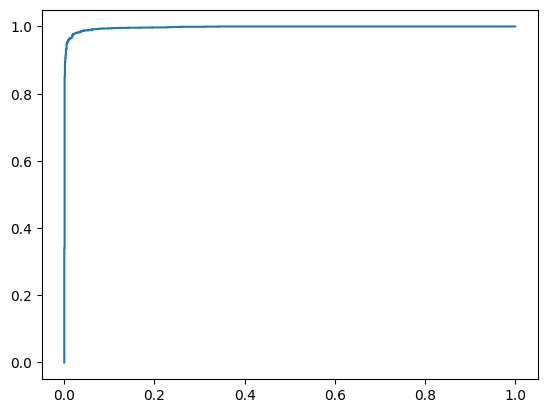

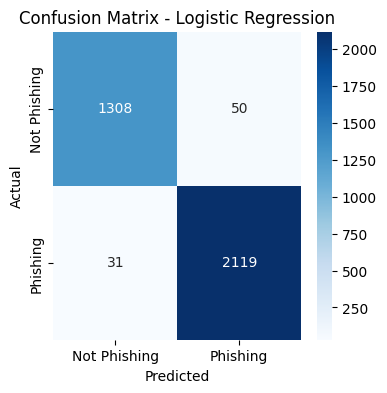


📌 Evaluating SVM...

  Cross-Validation Accuracy: 0.9760 ± 0.0021
  Training Time: 415.5378s, Prediction Time: 13.813164s
  Accuracy  = 0.9812
  Precision = 0.9802
  Recall    = 0.9893
  F1 Score  = 0.9847
  AUC-ROC   = 0.9788


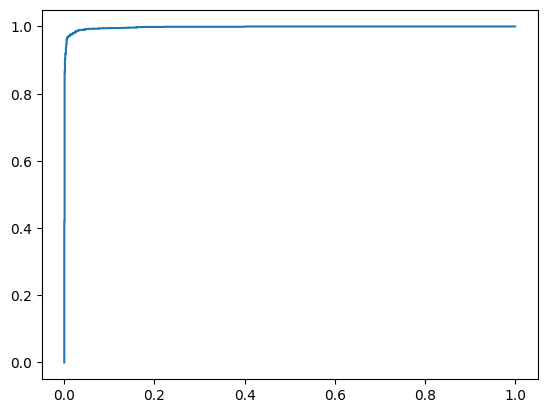

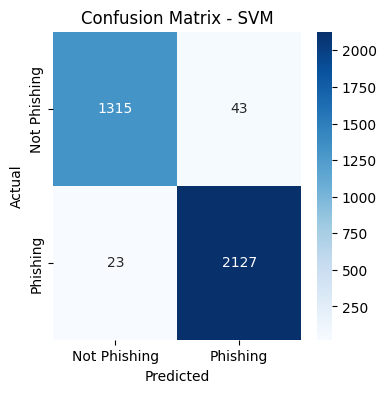


📌 Evaluating Naive Bayes...

  Cross-Validation Accuracy: 0.9646 ± 0.0035
  Training Time: 0.0103s, Prediction Time: 0.001920s
  Accuracy  = 0.9689
  Precision = 0.9692
  Recall    = 0.9805
  F1 Score  = 0.9748
  AUC-ROC   = 0.9656


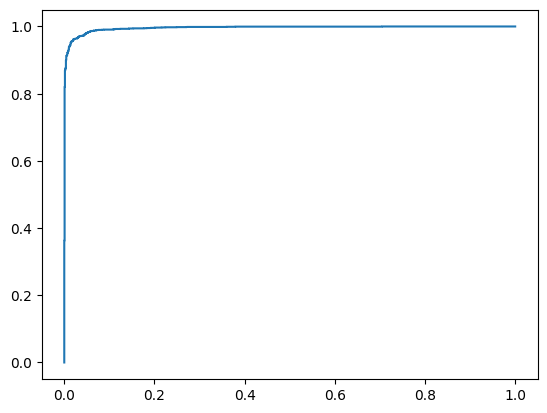

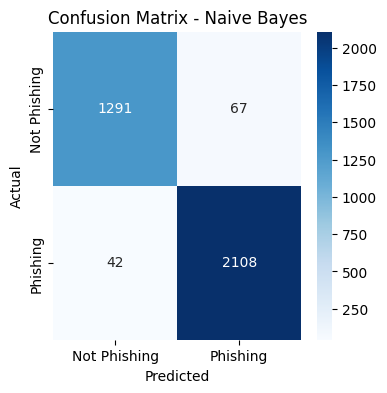


📌 Evaluating KNN...

  Cross-Validation Accuracy: 0.5246 ± 0.0032
  Training Time: 0.0080s, Prediction Time: 4.436498s
  Accuracy  = 0.5507
  Precision = 0.9815
  Recall    = 0.2721
  F1 Score  = 0.4261
  AUC-ROC   = 0.6320


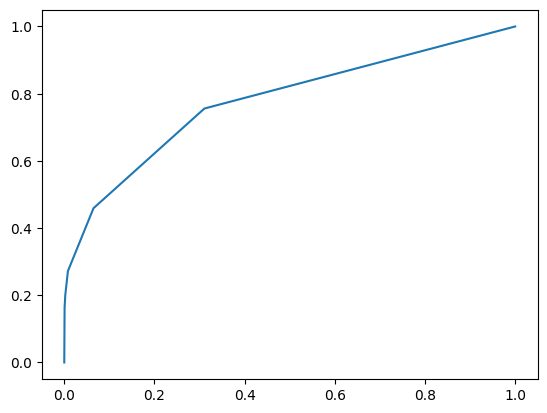

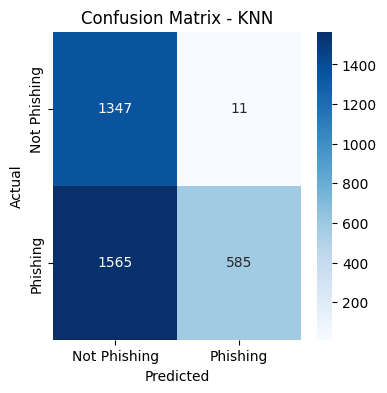

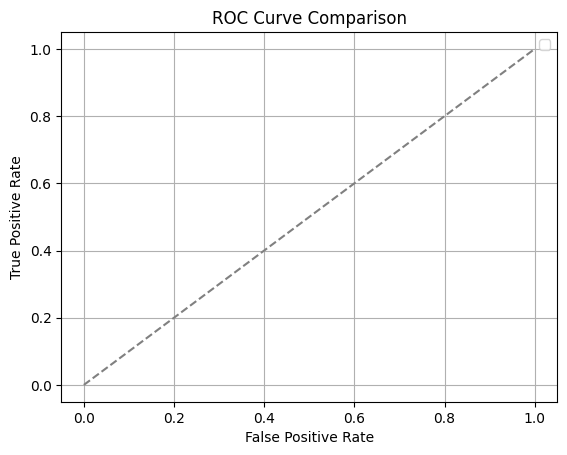


📋 Résultats Comparatifs :
                 Model  CV Accuracy Mean  CV Std  Train Time (s)  \
0        Random Forest            0.9659  0.0023         23.5564   
1              XGBoost            0.9616  0.0010         45.8504   
2  Logistic Regression            0.9690  0.0034          0.2970   
3                  SVM            0.9760  0.0021        415.5378   
4          Naive Bayes            0.9646  0.0035          0.0103   
5                  KNN            0.5246  0.0032          0.0080   

   Pred Time (s)  Accuracy  Precision  Recall  F1 Score  AUC-ROC  
0       0.168586    0.9746     0.9859  0.9726    0.9792   0.9955  
1       0.020154    0.9721     0.9808  0.9735    0.9771   0.9958  
2       0.001462    0.9769     0.9769  0.9856    0.9812   0.9971  
3      13.813164    0.9812     0.9802  0.9893    0.9847   0.9976  
4       0.001920    0.9689     0.9692  0.9805    0.9748   0.9955  
5       4.436498    0.5507     0.9815  0.2721    0.4261   0.7769  

✅ Résultats exportés dans 

In [11]:
results_df, trained_models = compare_models(x_full_train, x_full_test, y_full_train, y_full_test,output_csv="comparaison_modeles_tfidf_pross2.csv")

### XAI With LIME (TF-IDF)

In [12]:
best_model_name = results_df.sort_values(by='F1 Score', ascending=False).iloc[0]['Model']
best_model = trained_models[best_model_name]
print(f"\n🌟 Meilleur modèle (selon F1 Score) : {best_model_name}")

def predict_proba_from_texts(texts):
    transformed = tf.transform(texts)
    return best_model.predict_proba(transformed)

explainer = LimeTextExplainer(class_names=['Not Phishing', 'Phishing'])

idx =500
text_instance = df['Email Text processed'].iloc[idx]

exp = explainer.explain_instance(
text_instance,
predict_proba_from_texts,

)
exp.show_in_notebook(text=True)


🌟 Meilleur modèle (selon F1 Score) : SVM


## Compare Models for BERT

In [ ]:
models = {
            "Random Forest": RandomForestClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "SVM": SVC(probability=True),
            "KNN": KNeighborsClassifier(n_neighbors=5)
        }
results_df_bert, trained_models_bert = compare_models(X_train_bert, X_test_bert, y_train_bert, y_test_bert, models=models, output_csv="comparaison_modeles_bert_pross.csv")

### XAI With LIME (BERT)

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

def get_bert_cls_embeddings(emails, batch_size=32, device=None):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
    bert_model.eval()

    embeddings = []

    for i in tqdm(range(0, len(emails), batch_size), desc="Generating BERT embeddings"):
        batch_texts = emails[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = bert_model(**inputs)
            cls_tokens = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_tokens.cpu().numpy())

    return np.vstack(embeddings)

best_model_name = results_df_bert.sort_values(by='F1 Score', ascending=False).iloc[0]['Model']
best_model = trained_models_bert[best_model_name]
print(f"\n🌟 Meilleur modèle (selon F1 Score) : {best_model_name}")

email_embeddings = []
def predict_proba_from_texts(texts):
    email_embeddings = get_bert_cls_embeddings(texts)
    return best_model.predict_proba(email_embeddings)

explainer = LimeTextExplainer(class_names=['Not Phishing', 'Phishing'])

idx =70
text_instance = df['Email Text processed'].iloc[idx]

exp = explainer.explain_instance(
    text_instance,
    predict_proba_from_texts,

)
exp.show_in_notebook(text=True)

## Compare Models for Doc2Vec


📌 Evaluating Random Forest...

  Cross-Validation Accuracy: 0.9123 ± 0.0016
  Training Time: 23.4076s, Prediction Time: 0.067195s
  Accuracy  = 0.9156
  Precision = 0.9032
  Recall    = 0.9690
  F1 Score  = 0.9350
  AUC-ROC   = 0.8976


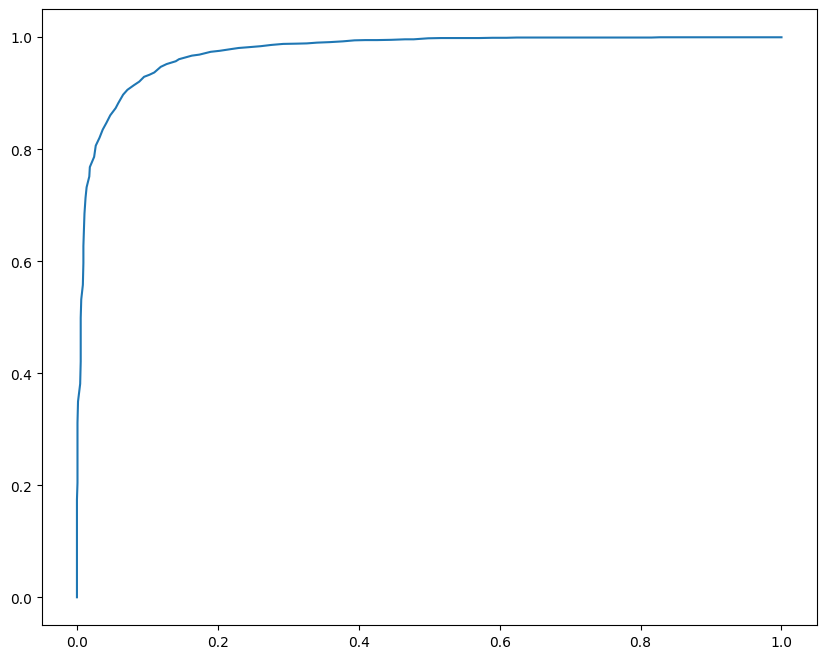

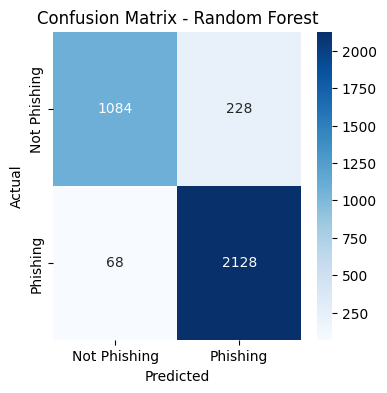


📌 Evaluating XGBoost...

  Cross-Validation Accuracy: 0.9364 ± 0.0033
  Training Time: 4.3430s, Prediction Time: 0.013246s
  Accuracy  = 0.9353
  Precision = 0.9437
  Recall    = 0.9536
  F1 Score  = 0.9486
  AUC-ROC   = 0.9291


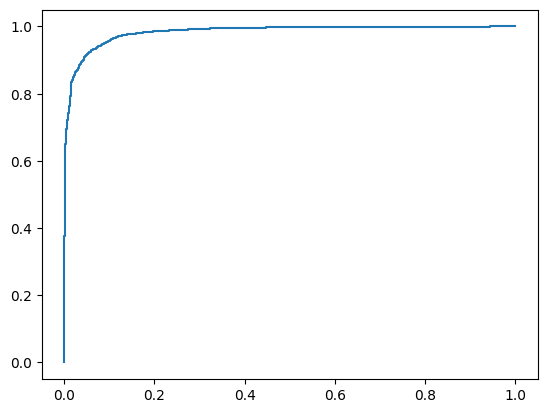

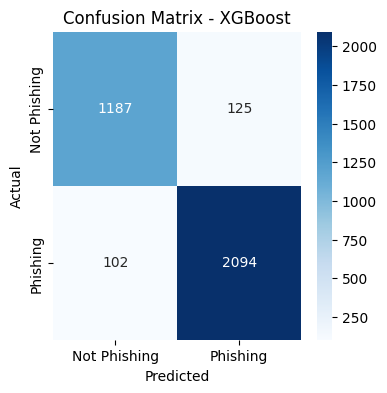


📌 Evaluating Logistic Regression...

  Cross-Validation Accuracy: 0.9116 ± 0.0010
  Training Time: 0.2398s, Prediction Time: 0.001724s
  Accuracy  = 0.9102
  Precision = 0.9193
  Recall    = 0.9390
  F1 Score  = 0.9290
  AUC-ROC   = 0.9005


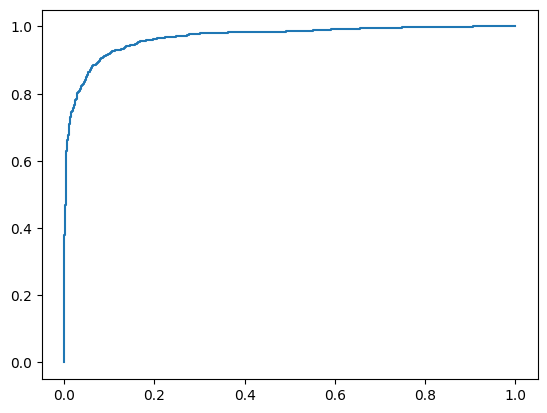

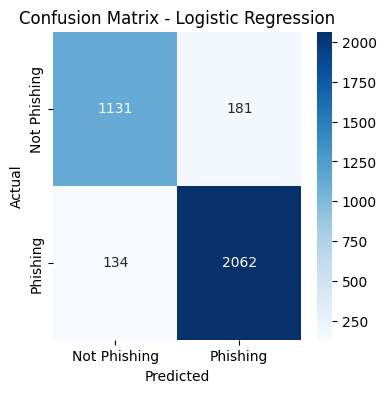


📌 Evaluating SVM...

  Cross-Validation Accuracy: 0.9340 ± 0.0024
  Training Time: 58.4351s, Prediction Time: 1.266272s
  Accuracy  = 0.9384
  Precision = 0.9361
  Recall    = 0.9677
  F1 Score  = 0.9516
  AUC-ROC   = 0.9286


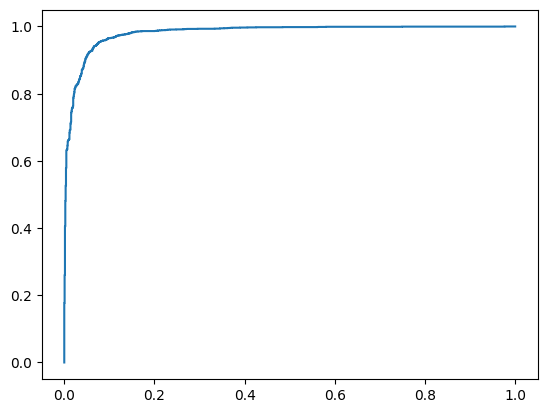

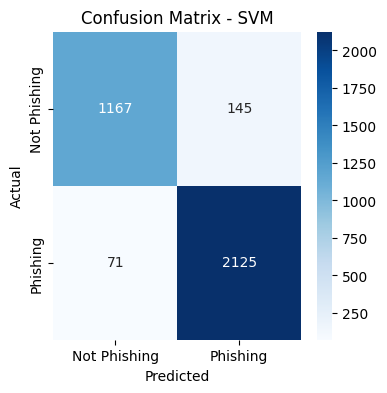


📌 Evaluating KNN...

  Cross-Validation Accuracy: 0.8705 ± 0.0072
  Training Time: 0.0029s, Prediction Time: 0.845214s
  Accuracy  = 0.8903
  Precision = 0.9023
  Recall    = 0.9249
  F1 Score  = 0.9134
  AUC-ROC   = 0.8786


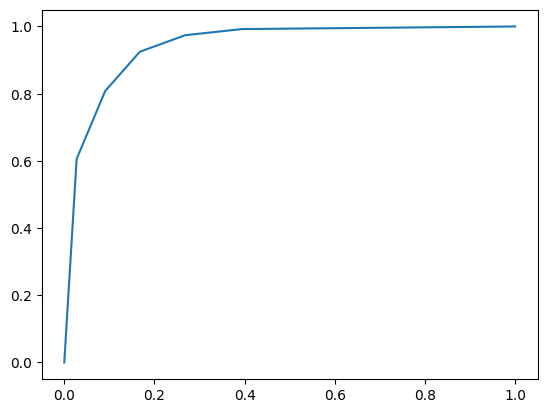

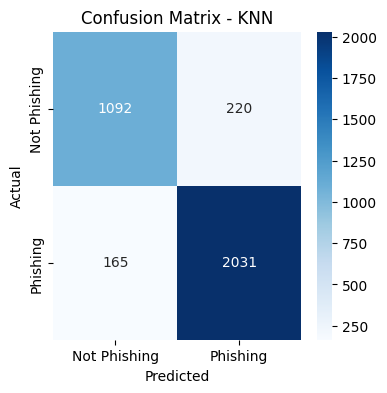

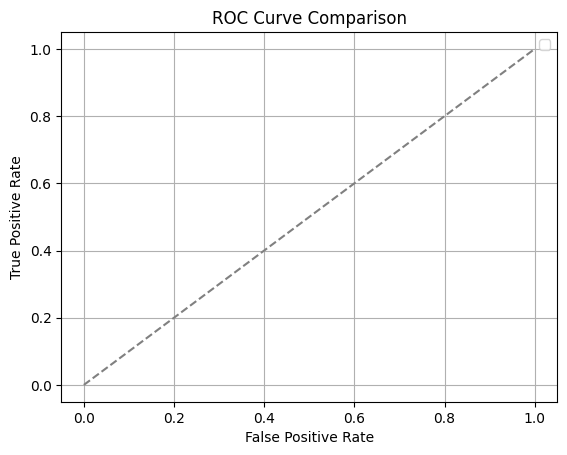


📋 Résultats Comparatifs :
                 Model  CV Accuracy Mean  CV Std  Train Time (s)  \
0        Random Forest            0.9123  0.0016         23.4076   
1              XGBoost            0.9364  0.0033          4.3430   
2  Logistic Regression            0.9116  0.0010          0.2398   
3                  SVM            0.9340  0.0024         58.4351   
4                  KNN            0.8705  0.0072          0.0029   

   Pred Time (s)  Accuracy  Precision  Recall  F1 Score  AUC-ROC  
0       0.067195    0.9156     0.9032  0.9690    0.9350   0.9745  
1       0.013246    0.9353     0.9437  0.9536    0.9486   0.9834  
2       0.001724    0.9102     0.9193  0.9390    0.9290   0.9679  
3       1.266272    0.9384     0.9361  0.9677    0.9516   0.9813  
4       0.845214    0.8903     0.9023  0.9249    0.9134   0.9425  

✅ Résultats exportés dans 'comparaison_modeles_doc2vec.csv'


In [13]:
models = {
            "Random Forest": RandomForestClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "SVM": SVC(probability=True),
            "KNN": KNeighborsClassifier(n_neighbors=5)
        }
results_df_doc, trained_models_doc = compare_models(X_train_doc, X_test_doc, y_train_doc, y_test_doc, models=models, output_csv="comparaison_modeles_doc2vec.csv")

## MLP Classifier

accuracy from MLP:97.95 %
f1 score from MLP: 98.32 %
classification report : 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1358
           1       0.98      0.98      0.98      2150

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



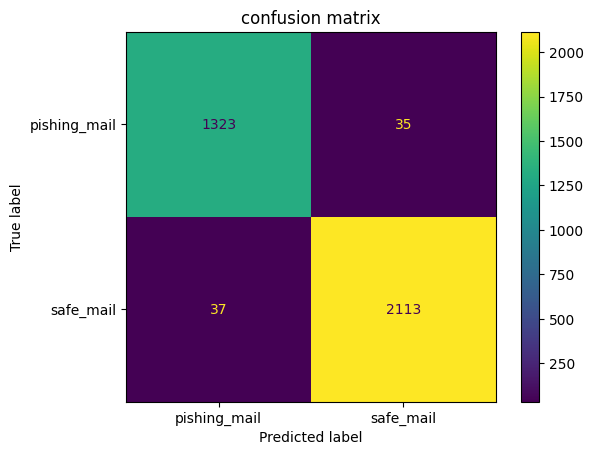

In [14]:
mlp = MLPClassifier()
mlp.fit(x_full_train,y_full_train)

pred_mlp = mlp.predict(x_full_test)

print(f"accuracy from MLP:{accuracy_score(y_full_test,pred_mlp)*100:.2f} %")
print(f"f1 score from MLP: {f1_score(y_full_test,pred_mlp)*100:.2f} %")
print("classification report : \n",classification_report(y_full_test,pred_mlp))

clf_mlp = confusion_matrix(y_full_test,pred_mlp)
cx_ = ConfusionMatrixDisplay(clf_mlp,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()